In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/code/ivankunyankin/googlenet-inception-from-scratch-using-pytorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(17)

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
#kaggle datasets download -d tusharpadhy/deepfake-dataset

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cecilia0999","key":"cc1406dbb42304ade9f37c8885076ba5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d tusharpadhy/deepfake-dataset

In [ ]:
! mkdir dataset
! unzip deepfake-dataset.zip -d dataset

In [1]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
import numpy as np
# Directories for your datasets
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
val_dir = '/content/dataset/valid'

# Transformation for resizing and converting images to Tensor
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
batch_size = 32
num_workers = 2
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

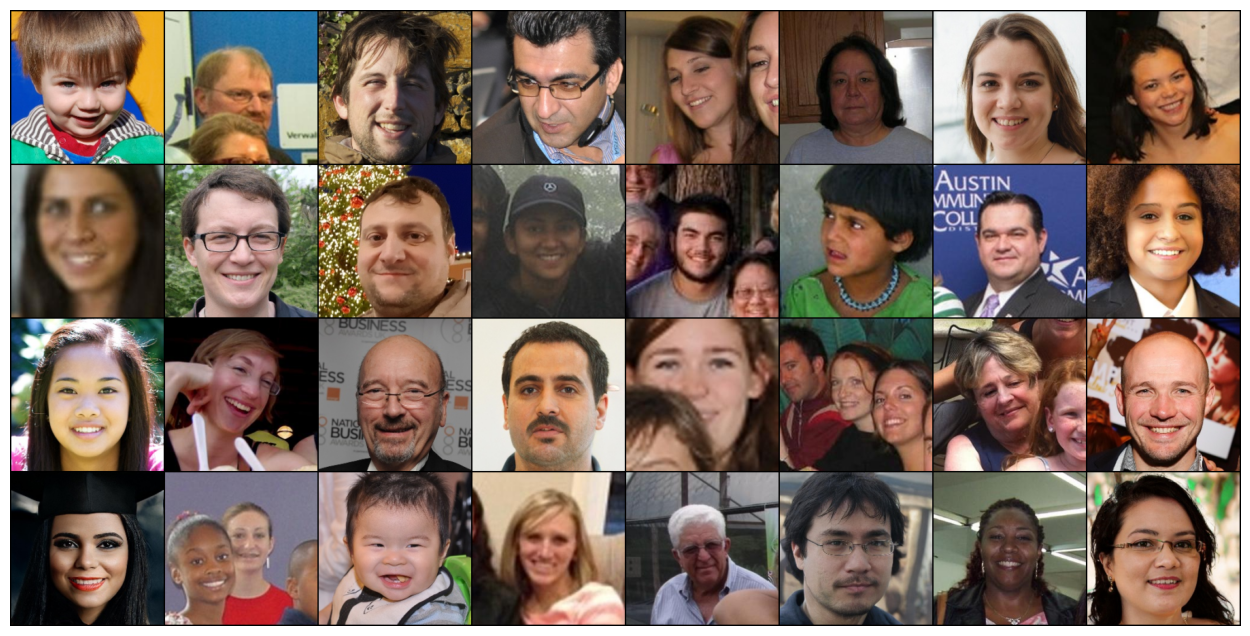

In [8]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [12]:
class Inception(nn.Module):

    def __init__(self, in_channels=3, use_auxiliary=True):
        super(Inception, self).__init__()

        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, 1)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512)
            self.auxiliary4d = Auxiliary(528)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)

        x = self.linear(x)
       # x = torch.sigmoid(x)

        return x, y, z

In [14]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [15]:
class InceptionBlock(nn.Module):

    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)

        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)

        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.one_by_one(x)

        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)

        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)

        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x

In [16]:
class Auxiliary(nn.Module):

    def __init__(self, in_channels):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 1)

        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
model = Inception()

In [18]:
#define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
model.to(device)
next(model.parameters()).is_cuda

False

In [19]:
epochs = 3 #50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
# @title No record
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, use_auxiliary=True):

    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device).float()  # Ensure labels are floats for BCEWithLogitsLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if phase == 'train':
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss_main = criterion(outputs, labels.view_as(outputs))
                            loss_aux1 = criterion(aux1, labels.view_as(aux1))
                            loss_aux2 = criterion(aux2, labels.view_as(aux2))
                            loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels.view_as(outputs))

                        preds = outputs.sigmoid().gt(0.5)  # Convert logits to binary predictions
                        loss.backward()
                        optimizer.step()

                    if phase == 'val':
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels.view_as(outputs))
                        preds = outputs.sigmoid().gt(0.5)

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.unsqueeze(1).data).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                lr_scheduler.step(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [4]:
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, use_auxiliary=True):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Iterate over data.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_samples = len(dataloaders[phase].dataset)
            steps_per_epoch = len(dataloaders[phase])

            progress_bar = tqdm(total=steps_per_epoch, desc=phase, position=0, leave=True)

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    if use_auxiliary and phase == 'train':
                        outputs, aux1, aux2 = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux1, labels)
                        loss3 = criterion(aux2, labels)
                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3
                    else:
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)

                    preds = outputs.sigmoid().gt(0.5).type_as(labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                progress_bar.update(1)

            progress_bar.close()
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print('{} {} [{}={}/{}] - loss: {:.4f} - acc: {:.4f}'.format(
                phase, ' ' * (5-len(phase)), 'x' * steps_per_epoch, steps_per_epoch, steps_per_epoch,
                epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [20]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)

Epoch 1/3
----------


train:   0%|          | 0/7501 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))